In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/gi-disease-detection")

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle as pkl

In [4]:
DATAPATH = "/content/drive/MyDrive/Colab Notebooks/gi-disease-detection/raw_data"

In [5]:
# DEFINE CONSTANTS
convert_to_gray = False
TARGET_SIZE = 128, 128

#### Create datasets

In [6]:
train_path = DATAPATH + '/train'
val_path = DATAPATH + '/val'
test_path = DATAPATH + '/test'
d_ = {'train': train_path,
      'val' : val_path,
      'test': test_path}
DIRS = [ _ for _ in os.listdir(train_path) if _ != '3_esophagitis']
DIRS

['1_ulcerative_colitis', '0_normal', '2_polyps']

In [7]:
for p in DIRS:
    print(p + " has :" + str(len(os.listdir(train_path + '/' + p))) + " entries")

1_ulcerative_colitis has :800 entries
0_normal has :800 entries
2_polyps has :800 entries


In [8]:
def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA

    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = float(w)/h 
    saspect = float(sw)/sh

    if (saspect > aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = float(sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0

    elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
        new_w = sw
        new_h = np.round(float(new_w) / aspect).astype(int)
        pad_vert = float(sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape)==3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

#### PREPROCESSING: RESIZING (including centering on frame)+ CONVERTING TO GREYSCALE (on demand) + save to .pkl

In [9]:
for k,v in enumerate(d_):
    l = []
    for i_, c_ in enumerate(DIRS):
        class_list = []
        for f in os.listdir(d_[v] + '/' + c_):
            path = d_[v] + '/' + c_ + '/' + f
            im_ = cv2.imread(path)
            out_ = resizeAndPad(im_,TARGET_SIZE)
            out_ = cv2.cvtColor(out_, cv2.COLOR_BGR2GRAY) if convert_to_gray == True else out_
            class_list.append(out_)
        l.append(class_list)
    arr_ = np.array(l)
    with open(v + '.pkl','wb') as f:
        pkl.dump(arr_, f)


#### START CNN MODELING FOR 2 CLASSES CLASSIF.

#### CREATING X_train, y_train

In [10]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [11]:
with open('train.pkl','rb') as f:
    x_ = pkl.load(f)
    x_ / 255.
X_train = np.vstack((x_[0,:,:,:],x_[1,:,:,:],x_[2,:,:,:] ))

y_train = []
for i_ in range(x_.shape[0]):
    y_tmp = [i_]* x_[i_].shape[0]
    y_train = y_train + y_tmp
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)
y_train_cat = to_categorical(y_train, 3)
print(y_train_cat.shape)

# final stage: shuffle the data
X_train, y_train_cat = shuffle(X_train, y_train_cat, random_state=42)
if convert_to_gray == True:
    X_train = np.expand_dims(X_train, axis=3)

print(X_train.shape)
print(y_train_cat.shape)

(2400, 128, 128, 3)
(2400,)
(2400, 3)
(2400, 128, 128, 3)
(2400, 3)


#### CREATING X_val, y_val

In [12]:
with open('val.pkl','rb') as f:
    x_ = pkl.load(f)
    x_ / 255.
X_val = np.vstack((x_[0,:,:,:],x_[1,:,:,:],x_[2,:,:,:] ))

y_val = []
for i_ in range(x_.shape[0]):
    y_tmp = [i_]* x_[i_].shape[0]
    y_val = y_val + y_tmp
y_val = np.array(y_val)

print(X_val.shape)
print(y_val.shape)
y_val_cat = to_categorical(y_val, 3)
print(y_val_cat.shape)

X_val, y_val_cat = shuffle(X_val, y_val_cat, random_state=42)
if convert_to_gray == True:
    X_val = np.expand_dims(X_val, axis=3)

print(X_val.shape)
print(y_val_cat.shape)

(1500, 128, 128, 3)
(1500,)
(1500, 3)
(1500, 128, 128, 3)
(1500, 3)


#### CREATING X_test, y_test

In [13]:
with open('test.pkl','rb') as f:
    x_ = pkl.load(f)
    x_ / 255.
X_test = np.vstack((x_[0,:,:,:],x_[1,:,:,:] ,x_[2,:,:,:]))

y_test = []
for i_ in range(x_.shape[0]):
    y_tmp = [i_]* x_[i_].shape[0]
    y_test = y_test + y_tmp
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)
y_test_cat = to_categorical(y_test, 3)
print(y_test_cat.shape)

X_test, y_test_cat = shuffle(X_test, y_test_cat, random_state=42)
if convert_to_gray == True:
    X_test = np.expand_dims(X_test, axis=3)
print(X_test.shape)
print(y_test_cat.shape)

(600, 128, 128, 3)
(600,)
(600, 3)
(600, 128, 128, 3)
(600, 3)


In [14]:
datagen_augmented = ImageDataGenerator(
                                        # featurewise_center=True,
                                        # featurewise_std_normalization=True,
                                        horizontal_flip=True,
                                        rotation_range=90, 
                                        width_shift_range=.2,
                                        height_shift_range=.2, 
                                        zoom_range=.2 )

datagen_augmented.fit(X_train)

# validation + test to not be affected by data augmentation
datagen_test_val = ImageDataGenerator()

X_train_data = datagen_augmented.flow(X_train, 
                                      y_train_cat,
                                      shuffle=True,#default value
                                      batch_size=32)
X_val_data = datagen_test_val.flow(X_val, 
                                   y_val_cat,
                                   shuffle=True,# default value
                                   batch_size=16)

In [15]:

from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.applications import efficientnet



In [16]:
def initialize_model():

    base_model= efficientnet.EfficientNetB5(include_top=False, 
                                            weights="imagenet",
                                            input_shape=X_train.shape[1:4],
                                            pooling='max') 
    base_model.trainable=True
    #base_model.trainable=False
    x = base_model.output
    x = BatchNormalization(axis=-1,
                           momentum=0.99,
                           epsilon=0.001 )(x)
    x = Dense(1024, 
              kernel_regularizer = regularizers.l2(l = 0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006),
              activation='relu')(x)
    x = Dropout(rate=.3, seed=123)(x)
    x = Dense(128, 
              kernel_regularizer = regularizers.l2(l = 0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=123)(x)        
    output=Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input,
                  outputs=output)
    return model


In [17]:

from tensorflow.keras.metrics import * 

def compile_model(model):
    lr=.001 # start with this learning rate
    
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = Adam(learning_rate=0.001),
                  metrics = ['accuracy', Precision(), Recall()])
    return model


In [18]:

model_ = initialize_model()
model_ = compile_model(model_)
model_.summary()


115263384/115263384 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)   

In [19]:

rlr = ReduceLROnPlateau(monitor="val_loss",
                        factor=0.5, 
                        patience=2,
                        verbose=1)

es  = EarlyStopping(monitor="val_loss", 
                    patience=5,
                    verbose=1,
                    restore_best_weights=True)

history_ = model_.fit(X_train_data, 
                      validation_data = X_val_data,
                      callbacks = [es, rlr], 
                      epochs = 30, 
                      batch_size = 32)


Epoch 1/30
75/75 [==============================] - 66s 457ms/step - loss: 17.9739 - accuracy: 0.8225 - precision: 0.8576 - recall: 0.7729 - val_loss: 65.2537 - val_accuracy: 0.8753 - val_precision: 0.8898 - val_recall: 0.8507 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - 28s 379ms/step - loss: 5.0027 - accuracy: 0.8700 - precision: 0.9017 - recall: 0.8221 - val_loss: 5.2953 - val_accuracy: 0.6013 - val_precision: 0.6183 - val_recall: 0.5487 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - 28s 371ms/step - loss: 1.4963 - accuracy: 0.9279 - precision: 0.9451 - recall: 0.9029 - val_loss: 1.2332 - val_accuracy: 0.7793 - val_precision: 0.8184 - val_recall: 0.7240 - lr: 0.0010
Epoch 4/30
75/75 [==============================] - 28s 372ms/step - loss: 0.7858 - accuracy: 0.9379 - precision: 0.9547 - recall: 0.9133 - val_loss: 0.6259 - val_accuracy: 0.9427 - val_precision: 0.9678 - val_recall: 0.9213 - lr: 0.0010
Epoch 5/30
75/75 [============================

In [20]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

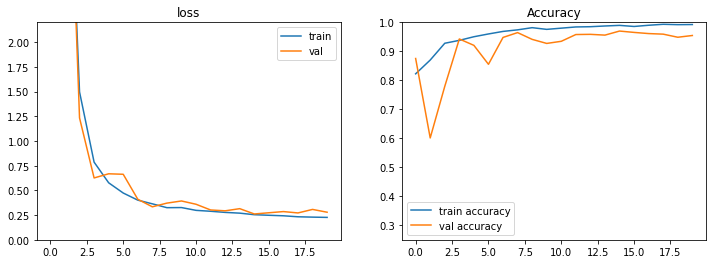

In [21]:
plot_history(history_)

In [34]:
# save model + retrain a few epochs starting at last learning rate value
model_.save_weights("model_efficientNetB5_20epochs.h5")

#### EVALUATE THE MODEL

In [23]:
X_test_data = datagen_test_val.flow(X_test, 
                                    y_test_cat,
                                    shuffle=True,# WARNING: default value
                                    batch_size=16)
model_.evaluate(X_test_data)

38/38 [==============================] - 3s 65ms/step - loss: 0.2417 - accuracy: 0.9767 - precision: 0.9765 - recall: 0.9717


[0.24169903993606567,
 0.9766666889190674,
 0.9765493869781494,
 0.971666693687439]

In [24]:
# Actual predict *MUST BE PERFORMED* on actual X_test,
# *NOT* on X_test_data which is an ImageDataGenerator object shuffles dataset by default

y_pred = model_.predict(X_test)
y_pred

19/19 [==============================] - 7s 111ms/step


array([[0.9683927 , 0.01081365, 0.0207937 ],
       [0.00975253, 0.00400128, 0.9862462 ],
       [0.08785601, 0.0596167 , 0.8525273 ],
       ...,
       [0.03292415, 0.94046193, 0.026614  ],
       [0.02273073, 0.01017099, 0.96709836],
       [0.9687187 , 0.01069646, 0.0205848 ]], dtype=float32)

In [25]:
print(y_pred[10:20,:])
print(y_test_cat[10:20,:])

[[0.96702194 0.01136324 0.02161482]
 [0.8283844  0.09007791 0.0815377 ]
 [0.96862787 0.01075831 0.02061381]
 [0.03740335 0.0210929  0.9415037 ]
 [0.0172007  0.96937805 0.01342123]
 [0.01137974 0.9799111  0.00870919]
 [0.962516   0.01308292 0.02440117]
 [0.01755785 0.96876097 0.01368117]
 [0.9631655  0.01282473 0.02400973]
 [0.98805517 0.00364275 0.00830214]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


#### FINAL SCORING + CONFUSION MATRIX

In [26]:
from sklearn.metrics import confusion_matrix,\
                            ConfusionMatrixDisplay
from sklearn.metrics import classification_report
y_prob = (y_pred>0.85).astype(int)  
print(classification_report(y_prob, y_test_cat))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       182
           1       1.00      1.00      1.00       200
           2       0.88      0.99      0.93       178

   micro avg       0.93      0.99      0.96       560
   macro avg       0.93      0.99      0.96       560
weighted avg       0.93      0.99      0.96       560
 samples avg       0.93      0.93      0.93       560



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


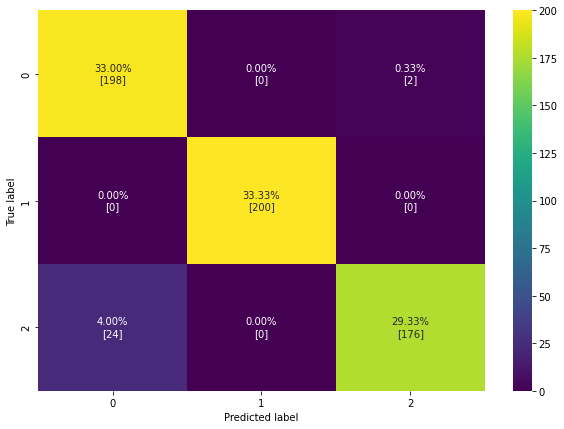

In [27]:
import seaborn as sns

y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(y_test_cat, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig = plt.figure(figsize=(10, 7))

# Handle label inside the boxes
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_total = cm.flatten()
labels = [f"{v2}\n[{v3}]" for v2,v3 in
          zip(group_percentages, group_total)]
labels = np.asarray(labels).reshape(3,3)

sns.heatmap(cm, annot=labels, fmt='', cmap = 'viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label');


#### PICK SOME SAMPLE THAT WORKS AND COMPARE PRED TO GROUND TRUTH

In [28]:
indexes = np.where(y_test_cat[:,0] != 1.)
indexes

(array([  1,   2,   5,   7,   9,  13,  14,  15,  17,  21,  22,  23,  24,
         25,  28,  29,  30,  33,  35,  37,  38,  39,  40,  42,  43,  46,
         49,  50,  51,  53,  54,  55,  56,  62,  63,  64,  66,  67,  69,
         70,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         87,  88,  89,  90,  91,  93,  94,  95,  96,  98, 101, 102, 103,
        105, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 122,
        123, 126, 127, 128, 129, 131, 134, 138, 141, 144, 146, 147, 150,
        151, 152, 153, 154, 155, 157, 160, 161, 163, 164, 166, 167, 168,
        169, 170, 171, 172, 173, 176, 179, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 201, 202,
        204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 216, 218, 221,
        223, 224, 225, 226, 227, 229, 231, 232, 233, 234, 236, 237, 238,
        239, 240, 241, 242, 245, 246, 247, 253, 256, 257, 259, 260, 261,
        262, 264, 265, 266, 269, 270, 271, 274, 275

In [29]:
sample_idx = 511
X_sample = np.expand_dims(X_test[sample_idx,:,:,:], axis=0)
print(X_sample.shape)
y_pred_sample = model_.predict(X_sample)
print(y_pred_sample)
print(y_test_cat[sample_idx])


(1, 128, 128, 3)
1/1 [==============================] - 1s 720ms/step
[[0.03005155 0.9457913  0.02415717]]
[0. 1. 0.]


In [30]:
from sklearn.metrics import confusion_matrix,\
                            ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [31]:
y_pred = model_.predict(X_test_data)
y_prob = (y_pred>0.4).astype(int)  
print(classification_report(y_prob, y_test_cat))

38/38 [==============================] - 6s 42ms/step
              precision    recall  f1-score   support

           0       0.33      0.33      0.33       199
           1       0.34      0.33      0.33       201
           2       0.39      0.39      0.39       201

   micro avg       0.35      0.35      0.35       601
   macro avg       0.35      0.35      0.35       601
weighted avg       0.35      0.35      0.35       601
 samples avg       0.35      0.35      0.35       601



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
